# Filtering the full MovieLens dataset to get the 100k dataset that results in best KNN model

## Introduction

The MovieLens Latest Full dataset consists of 33 million ratings and 2 million tags applied to 86,000 movies by 330,975 users. While it is great for building models, it is computationally expensive to train models on the full dataset. In this notebook, we will attempt to mimic the MovieLens Latest Small dataset by filtering the full dataset to get the 100k dataset that results in the best item(movie) based KNN model. 100k is roughly 1/300 of the full dataset, which is the same ratio as the MovieLens Latest Small dataset to the MovieLens Latest Full dataset.

## Benchmarking the model

In this notebook, we will filter the full MovieLens dataset to get the 100k dataset that results in the best item(movie) based KNN model. We will use the RMSE metric to evaluate the model performance. This means we generate ratings for users in the test set and compare them with the actual ratings. The lower the RMSE, the better the model.

## Steps

1. Load the full MovieLens dataset
2. Filter the dataset to get the 100k dataset (using different thresholds)
3. Split the dataset into train and test sets
4. Train the KNN model using the train set
5. Evaluate the model using the test set


In [1]:
# load the ml-latest full dataset into a pandas dataframe
import pandas as pd
ratings = pd.read_csv('ml-latest/ml-latest/ratings.csv')

print(ratings.head())
print(ratings.shape)

   userId  movieId  rating   timestamp
0       1        1     4.0  1225734739
1       1      110     4.0  1225865086
2       1      158     4.0  1225733503
3       1      260     4.5  1225735204
4       1      356     5.0  1225735119
(33832162, 4)


userId
1    62
2    91
3    30
4    30
5    43
dtype: int64 (330975,)
33332 189614
userId
1    62
2    91
3    30
4    30
5    43
dtype: int64 (330775,)


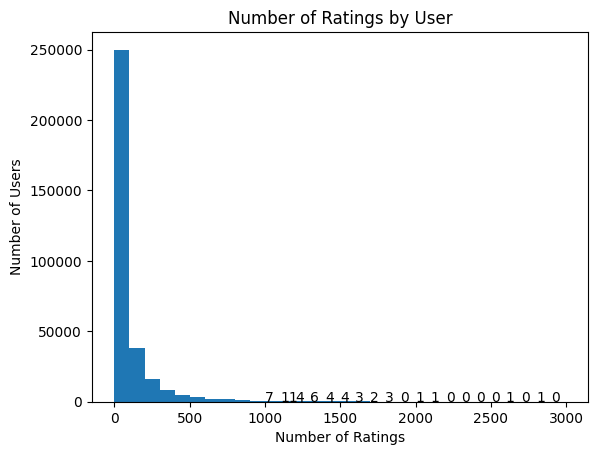

In [3]:
# graph the number of ratings (x) and how many users rated that many movies (y) with number of users in each bucket (30) on top of bar
import matplotlib.pyplot as plt

# find the number of ratings by each user
user_rating_counts = ratings.groupby('userId').size()
print(user_rating_counts.head(), user_rating_counts.shape)
# find the max number of ratings by a user and the user id
max_user_ratings = user_rating_counts.max()
max_user_id = user_rating_counts.idxmax()
print(max_user_ratings, max_user_id)
# remove outliers from the data (say, users who rated more than 3000 movies)
user_rating_counts = user_rating_counts[user_rating_counts < 3000]
print(user_rating_counts.head(), user_rating_counts.shape)

plt.hist(user_rating_counts, bins=30)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.title('Number of Ratings by User')
for i in range(1000, 3000, 100):
    plt.text(i, 100, user_rating_counts[user_rating_counts == i].shape[0])
plt.show()

## Initial Analysis

It seems like most user has rated less than 100 movies. However, it might be a good idea to include users who have rated more movies as they are more likely movie enthusiasts and their ratings might be more reliable. 

## Filtering the dataset

So we want to make sure that we have 100k or around 100k ratings in the dataset. We can roughly do the following:

1. Choose 100k ratings randomly from the users who have rated the least number of movies (more users)
2. Choose 100k ratings randomly from the users who have rated the most number of movies (more ratings per user)
3. Choose 50k ratings randomly from the users who have rated the least number of movies and 50k ratings randomly from the users who have rated the most number of movies
4. Choose 100k ratings from the median number of ratings per user
5. Choose 100k ratings from all users

(21933, 4)
(33810229, 4)


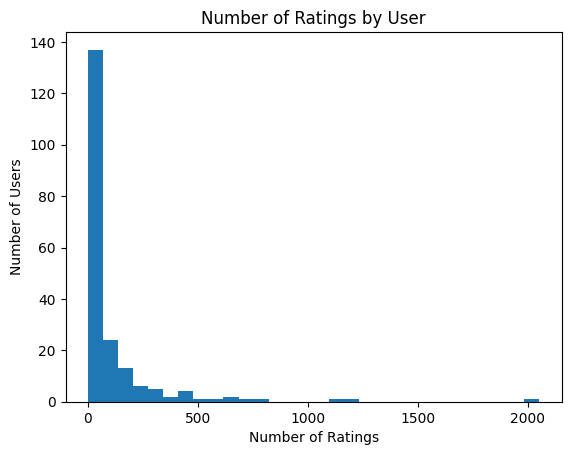

In [4]:
# Randomly sample 500 users, remove them from the dataset and plot the number of ratings by user
import numpy as np
np.random.seed(0)

# split the data into test and train where the test data is 200 users
test_users = np.random.choice(user_rating_counts.index, 200, replace=False)
test_ratings = ratings[ratings['userId'].isin(test_users)]
print(test_ratings.shape)
train_ratings = ratings[~ratings['userId'].isin(test_users)]
print(train_ratings.shape)

test_user_rating_counts = test_ratings.groupby('userId').size()
plt.hist(test_user_rating_counts, bins=30)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.title('Number of Ratings by User')
plt.show()

In [4]:
# 1. Choose 100k ratings randomly from users who have rated less than 100 movies
def one(train_ratings):
    train_ratings_cpy = train_ratings.copy()
    # find the users who have rated less than 100 movies
    user_rating_counts = train_ratings_cpy.groupby('userId').size()
    user_rating_counts = user_rating_counts[user_rating_counts < 100]
    print(user_rating_counts.shape)
    # randomly sample 100k ratings from these users
    sample_ratings = train_ratings_cpy[train_ratings_cpy['userId'].isin(user_rating_counts.index)].sample(100000)
    print(sample_ratings.shape)
    return sample_ratings


In [5]:
# 2. Choose 100k ratings randomly from users who have rated more than 1000 movies
def two(train_ratings):
    train_ratings_cpy = train_ratings.copy()
    # find the users who have rated more than 1000 movies
    user_rating_counts = train_ratings_cpy.groupby('userId').size()
    user_rating_counts = user_rating_counts[user_rating_counts > 1000]
    print(user_rating_counts.shape)
    # randomly sample 100k ratings from these users
    sample_ratings = train_ratings_cpy[train_ratings_cpy['userId'].isin(user_rating_counts.index)].sample(100000)
    print(sample_ratings.shape)
    return sample_ratings

In [6]:
# 3. Choose 50k ratings randomly from users who have rated more than 1000 movies and 50k from users who have rated less than 100 movies
def three(train_ratings):
    train_ratings_cpy = train_ratings.copy()
    # find the users who have rated more than 1000 movies
    user_rating_counts = train_ratings_cpy.groupby('userId').size()
    user_rating_counts = user_rating_counts[user_rating_counts > 1000]
    print(user_rating_counts.shape)
    # randomly sample 50k ratings from these users
    sample_ratings = train_ratings_cpy[train_ratings_cpy['userId'].isin(user_rating_counts.index)].sample(50000)
    # find the users who have rated less than 100 movies
    user_rating_counts = train_ratings_cpy.groupby('userId').size()
    user_rating_counts = user_rating_counts[user_rating_counts < 100]
    print(user_rating_counts.shape)
    # randomly sample 50k ratings from these users and append to the previous sample (dataframe)
    sample_ratings = pd.concat([sample_ratings, train_ratings_cpy[train_ratings_cpy['userId'].isin(user_rating_counts.index)].sample(50000)])
    print(sample_ratings.shape)
    return sample_ratings

In [7]:
# 4. Choose 100k ratings randomly from users who have rated between 200 and 500 movies (middle of the road)
def four(train_ratings):
    train_ratings_cpy = train_ratings.copy()
    # find the users who have rated between 200 and 500 movies
    user_rating_counts = train_ratings_cpy.groupby('userId').size()
    user_rating_counts = user_rating_counts[(user_rating_counts > 200) & (user_rating_counts < 500)]
    print(user_rating_counts.shape)
    # randomly sample 100k ratings from these users
    sample_ratings = train_ratings_cpy[train_ratings_cpy['userId'].isin(user_rating_counts.index)].sample(100000)
    print(sample_ratings.shape)
    return sample_ratings

In [8]:
# 5. Choose 100k ratings randomly by splitting the data into 50 buckets of users and choosing 2k ratings from each bucket
def five(train_ratings):
    train_ratings_cpy = train_ratings.copy()
    # split the data into 50 buckets of users based on the number of ratings
    user_rating_counts = train_ratings_cpy.groupby('userId').size()
    user_rating_counts = user_rating_counts.sort_values()
    buckets = np.array_split(user_rating_counts.index, 50)
    print([len(bucket) for bucket in buckets])
    # randomly sample 2k ratings from each bucket
    sample_ratings = pd.concat([train_ratings_cpy[train_ratings_cpy['userId'].isin(bucket)].sample(2000) for bucket in buckets])
    print(sample_ratings.shape)
    return sample_ratings

In [9]:
train1 = one(train_ratings)
train2 = two(train_ratings)
train3 = three(train_ratings)
train4 = four(train_ratings)
train5 = five(train_ratings)

(248778,)
(100000, 4)
(3648,)
(100000, 4)
(3648,)
(248778,)
(100000, 4)
(29819,)
(100000, 4)
[6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6616, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615, 6615]
(100000, 4)


## What now?

Now that we have all the training data sets and the testing data set, we can start the benchmarking process. We will train the KNN model on each of the training data sets and evaluate the model on the testing data set. We will then compare the RMSE values to determine the best data set to use for the KNN model.

In [8]:
# function to train and evaluate the KNN model, and return the RMSE and MAE value
from surprise import Dataset, Reader, KNNBasic

def train_and_evaluate(train, test):
    reader = Reader(rating_scale=(1, 5))
    train_data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)
    trainset = train_data.build_full_trainset()
    test_data = Dataset.load_from_df(test[['userId', 'movieId', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    algo = KNNBasic(
        k=40,   # maximum number of neighbors to consider for aggregation (when making predictions)
        sim_options={
            'name': 'cosine',
            'user_based': False
        }
    )
    algo.fit(trainset)
    predictions = algo.test(testset)
    from surprise import accuracy
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    return rmse, mae

In [11]:
# evaluate the models and plot the RMSE and MAE values for each model
rmse1, mae1 = train_and_evaluate(train1, test_ratings)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0656
MAE:  0.8302


(100000, 4)
movieId
1    55
2    43
3    24
4     6
5    18
dtype: int64 (17579,)


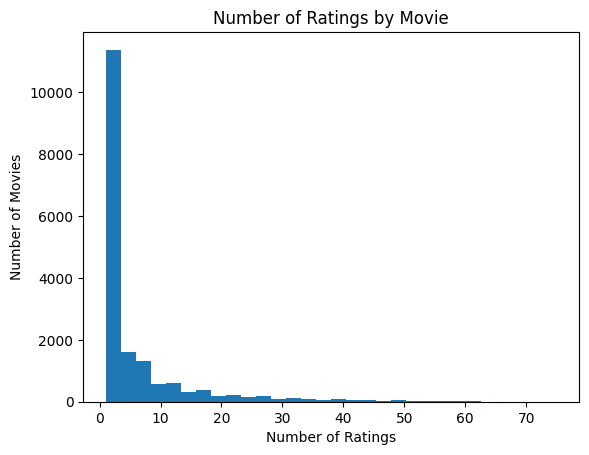

In [12]:
# rmse2, mae2 = train_and_evaluate(train2, test_ratings)
rmse2, mae2 = 0,0
# This attempts to allocate more than 12gb of memory and crashes the kernel, so we need to cut down the number of movies
# in the train2 dataset

# check the number of movies in train2 and group it by the number of ratings, then graph it
print(train2.shape)
train2_movie_rating_counts = train2.groupby('movieId').size()
print(train2_movie_rating_counts.head(), train2_movie_rating_counts.shape)

plt.hist(train2_movie_rating_counts, bins=30)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Number of Ratings by Movie')
plt.show()

(80036, 4)
movieId
1    55
2    43
3    24
4     6
5    18
dtype: int64 (5353,)


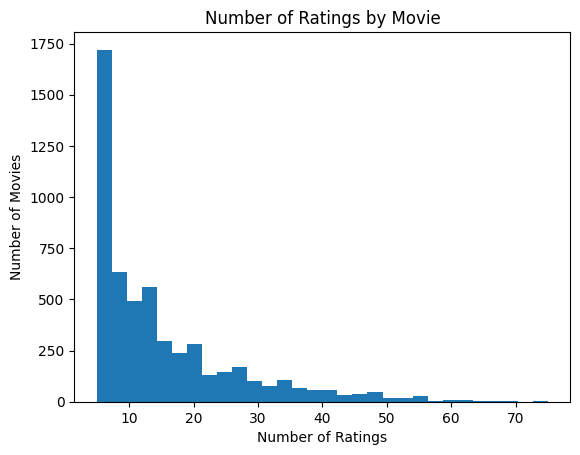

In [13]:
# As we can see there are 17579 movies, out of which more than 10000 have less than 5 ratings.
# To reduce the number of movies, we can remove half of those movies

# remove the movies with less than 2 ratings
train2_movie_rating_counts = train2_movie_rating_counts[train2_movie_rating_counts >= 5]
train2 = train2[train2['movieId'].isin(train2_movie_rating_counts.index)]

# check the number of movies in train2 and group it by the number of ratings, then graph it
print(train2.shape)
train2_movie_rating_counts = train2.groupby('movieId').size()
print(train2_movie_rating_counts.head(), train2_movie_rating_counts.shape)

plt.hist(train2_movie_rating_counts, bins=30)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Number of Ratings by Movie')
plt.show()

In [14]:
# Now this seems more reasonable, so we can evaluate the model
rmse2, mae2 = train_and_evaluate(train2, test_ratings)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0989
MAE:  0.9148


(100000, 4)
movieId
1    258
2     71
3     65
4     11
5     80
dtype: int64 (13616,)


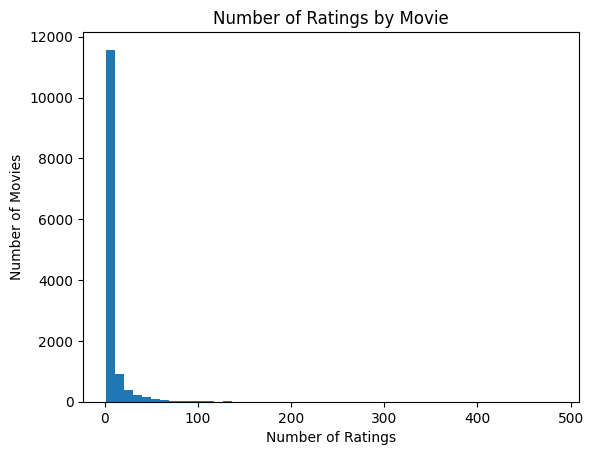

In [15]:
# rmse3, mae3 = train_and_evaluate(train3, test_ratings)
# This also wouldn't work because we need to limit the number of movies in train3

# check the number of movies in train3 and group it by the number of ratings, then graph it
print(train3.shape)
train3_movie_rating_counts = train3.groupby('movieId').size()
print(train3_movie_rating_counts.head(), train3_movie_rating_counts.shape)

plt.hist(train3_movie_rating_counts, bins=50)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Number of Ratings by Movie')
plt.show()

(73129, 4)
movieId
1    258
2     71
3     65
4     11
5     80
dtype: int64 (2214,)


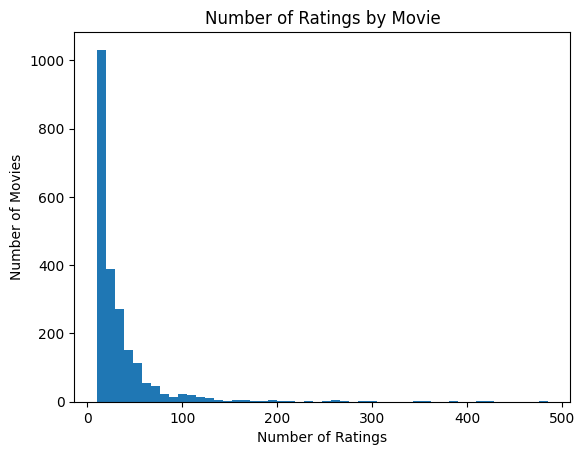

In [16]:
# as we can see there are too many movies with less than 10 ratings, so we need to remove some of them
train3_movie_rating_counts = train3_movie_rating_counts[train3_movie_rating_counts >= 10]
train3 = train3[train3['movieId'].isin(train3_movie_rating_counts.index)]

# check the number of movies in train3 and group it by the number of ratings, then graph it
print(train3.shape)
train3_movie_rating_counts = train3.groupby('movieId').size()
print(train3_movie_rating_counts.head(), train3_movie_rating_counts.shape)

plt.hist(train3_movie_rating_counts, bins=50)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Number of Ratings by Movie')
plt.show()

In [17]:
# This seems more reasonable, so we can evaluate the model
rmse3, mae3 = train_and_evaluate(train3, test_ratings)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0549
MAE:  0.8402


In [18]:
rmse4, mae4 = train_and_evaluate(train4, test_ratings)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0549
MAE:  0.8412


In [19]:
rmse5, mae5 = train_and_evaluate(train5, test_ratings)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0606
MAE:  0.8332


In [20]:
# Now we try the same thing using the 100k dataset provided by MovieLens
ratings = pd.read_csv('ml-latest-small/ml-latest-small/ratings.csv')

# split the data into test and train where the test data is 200 users
test_users = np.random.choice(ratings['userId'].unique(), 200, replace=False)
test_ratings = ratings[ratings['userId'].isin(test_users)]
print(test_ratings.shape)
train_ratings = ratings[~ratings['userId'].isin(test_users)]
print(train_ratings.shape)

rmse6, mae6 = train_and_evaluate(train_ratings, test_ratings)

(33651, 4)
(67185, 4)
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0300
MAE:  0.8188


[1.0656372246326984, 1.0988818683366137, 1.0549495615792714, 1.0549005848961501, 1.0605692835439267, 1.0300112521799025]
[0.8302186324260247, 0.9148133072256273, 0.8402187048638553, 0.841185215656773, 0.8331667612729676, 0.8188038062015587]


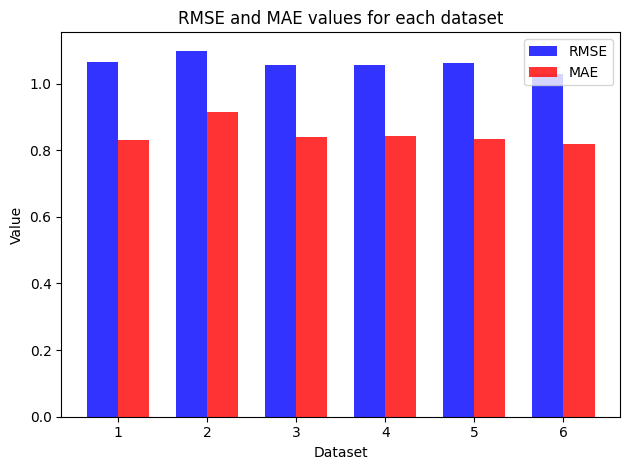

In [21]:
# Graph the RMSE and MAE values for each dataset as a bar graph

import matplotlib.pyplot as plt

labels = ['1', '2', '3', '4', '5', '6']
rmse = [rmse1, rmse2, rmse3, rmse4, rmse5, rmse6]
print(rmse)
mae = [mae1, mae2, mae3, mae4, mae5, mae6]
print(mae)

x = range(len(labels))

fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(x, rmse, bar_width, alpha=opacity, color='b', label='RMSE')
rects2 = plt.bar([p + bar_width for p in x], mae, bar_width, alpha=opacity, color='r', label='MAE')

plt.xlabel('Dataset')
plt.ylabel('Value')
plt.title('RMSE and MAE values for each dataset')
plt.xticks([p + bar_width/2 for p in x], labels)
plt.legend()

plt.tight_layout()
plt.show()

## Analysis of preliminary results

<!-- As we can see from the data and graph above, both model1 and model5 performed better than the ML-Small dataset, where model1 has better MAE and model5 has better RMSE. Since we are more interested in providing accurate recommendation (least variation regardless of overestimation or underestimation), we will choose model5 as the best dataset to use for the KNN model. Also, we can attempt to combine model1 and model 5 to see if we can get a better model.  -->

As we can see from the data and graph above, none of the five datasets performed better compared to the ML-Small dataset. So we must change our approach to get a better dataset.

## New Approach

Dataset 2 and 3 have the worst RMSE values, because they include users who have rated a ton of movies, which were then removed because they causes the similarity matrix to be too large. So it is unwise to include those samples in our dataset. What we can try instead is to iteratively remove unpopular movies and users who have rated very few movies. This way, we can get a dataset that is more balanced and has a better RMSE value.

In [5]:
# We can make it so that the similarity matrix takes up around 2gb of memory
memory_limit_gb = 2

# compute how many movies we can have in the similarity matrix
from math import sqrt
num_movies = int(sqrt(memory_limit_gb * 10**9 / 8))
print(num_movies)   # 15811


15811


In [6]:
def most_popular_movies(train_ratings, num_movies):
    # find the most popular movies
    movie_rating_counts = train_ratings.groupby('movieId').size()
    movie_rating_counts = movie_rating_counts.sort_values(ascending=False)
    movie_rating_counts = movie_rating_counts.head(num_movies)
    print(movie_rating_counts.shape)
    # get the ratings for these movies
    popular_movies = train_ratings[train_ratings['movieId'].isin(movie_rating_counts.index)]
    print(popular_movies.shape)
    return popular_movies

In [9]:
# Now re-run cells on the top to get the train and test split

train_popular = most_popular_movies(train_ratings, num_movies) 

rmse_popular, mae_popular = train_and_evaluate(train_popular, test_ratings)

(15811,)
(33295938, 4)


: 